<a href="https://colab.research.google.com/github/TimH2024/MSC-M5-Project/blob/main/6_Std_dataset_LTSM_Timestamp%2C_ensemble_models_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. LSTM Timestamp & Ensemble Model

# LOAD LIBRARIES

In [ ]:
!pip install tensorflow keras keras-tuner numpy pandas scikit-learn
!pip install python-docx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Core libraries
import numpy as np
import pandas as pd

from google.colab import drive

import matplotlib.pyplot as plt

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from tabulate import tabulate
import datetime

# Keras Tuner for hyperparameter tuning
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold


# LOAD FILE FROM PREVIOUS CODE BLOCK

In [ ]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the file path in Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/Std_Datasetv6.csv'

# Read the file into a DataFrame
try:
    merged_dataset = pd.read_csv(file_path)
    print("[INFO] File loaded successfully into 'merged_dataset'.")
    print(merged_dataset.head())  # Display the first 5 rows
except FileNotFoundError:
    print(f"[ERROR] File not found at '{file_path}'. Please check the file path and try again.")
except Exception as e:
    print(f"[ERROR] An error occurred while reading the file: {e}")

Mounted at /content/drive
[INFO] File loaded successfully into 'merged_dataset'.
   saleable_area(ft^2)  unit_rate     floor       CPI        IR        MW  \
0             0.260534  -0.314185  1.757769  1.318729 -1.059593 -1.524527   
1             0.223632  -0.424514  0.501134  1.318729 -1.059593 -1.524527   
2            -0.390423  -0.383380 -0.001520  1.318729 -1.059593 -1.524527   
3             1.857067  -1.080034  0.878125  1.318729 -1.059593 -1.524527   
4             1.163345  -0.751664  0.417359  1.318729 -1.059593 -1.524527   

         M3        UR       GDP        CI  ...  floor_height_floor_46to50  \
0 -0.604983  2.994659 -3.472663  1.115625  ...                  -0.123415   
1 -0.604983  2.994659 -3.472663  1.115625  ...                  -0.123415   
2 -0.604983  2.994659 -3.472663  1.115625  ...                  -0.123415   
3 -0.604983  2.994659 -3.472663  1.115625  ...                  -0.123415   
4 -0.604983  2.994659 -3.472663  1.115625  ...                  -0.1234

In [ ]:
merged_dataset.shape

(105114, 71)

In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105114 entries, 0 to 105113
Data columns (total 71 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   saleable_area(ft^2)                             105114 non-null  float64
 1   unit_rate                                       105114 non-null  float64
 2   floor                                           105114 non-null  float64
 3   CPI                                             105114 non-null  float64
 4   IR                                              105114 non-null  float64
 5   MW                                              105114 non-null  float64
 6   M3                                              105114 non-null  float64
 7   UR                                              105114 non-null  float64
 8   GDP                                             105114 non-null  float64
 9   CI                        

# LSTM WITH TIME STAMP
(by espressly utilising the scaled timestamp such that it is not just another feature)

In [ ]:
# Define the feature matrix (X) and target variables (y)

features = merged_dataset.drop(columns=['new_price', 'PC'])
targets_Std = merged_dataset[['new_price', 'PC']]

X = features.copy()
y = targets_Std.copy()

In [ ]:

# Combine Year, Month, and Day columns into a single Timestamp column
merged_dataset['Timestamp'] = pd.to_datetime(merged_dataset[['Year', 'Month', 'Day']])

# Convert Timestamp to numeric (e.g., elapsed days since the minimum date in the dataset)
merged_dataset['ElapsedTimestamp'] = (merged_dataset['Timestamp'] - merged_dataset['Timestamp'].min()).dt.total_seconds()

# Scale the ElapsedTimestamp to a range of [0, 1]
scaler = MinMaxScaler()
merged_dataset['ScaledTimestamp'] = scaler.fit_transform(merged_dataset[['ElapsedTimestamp']])

# Drop intermediate columns if not needed
merged_dataset = merged_dataset.drop(columns=['Timestamp', 'ElapsedTimestamp'])

# Define the feature matrix (X) and target variables (y)
features = merged_dataset.drop(columns=['new_price', 'PC'])
targets_Std = merged_dataset[['new_price', 'PC']]

X = features.copy()
y = targets_Std.copy()

In [ ]:
def prepare_lstm_data(X, y, time_steps=10):
    """
    Prepare sequences of features and corresponding targets for LSTM.

    Args:
    - X (ndarray): Feature matrix.
    - y (ndarray): Target vector.
    - time_steps (int): Number of time steps for each sequence.

    Returns:
    - X_seq (ndarray): Feature sequences of shape (samples, time_steps, features).
    - y_seq (ndarray): Target sequences of shape (samples,).
    """
    X_values, y_values = np.array(X), np.array(y)

    X_seq, y_seq = [], []
    for i in range(len(X_values) - time_steps):
        X_seq.append(X_values[i:i + time_steps])
        y_seq.append(y_values[i + time_steps])

    return np.array(X_seq), np.array(y_seq)

# Prepare the LSTM data
time_steps = 10  # Define the number of time steps
X_lstm, y_lstm = prepare_lstm_data(X, y, time_steps=time_steps)

# Print shapes of resulting arrays
print(f"Shape of X_lstm: {X_lstm.shape}")  # (samples, time_steps, features)
print(f"Shape of y_lstm: {y_lstm.shape}")  # (samples, targets)

Shape of X_lstm: (105104, 10, 70)
Shape of y_lstm: (105104, 2)


In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105114 entries, 0 to 105113
Data columns (total 72 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   saleable_area(ft^2)                             105114 non-null  float64
 1   unit_rate                                       105114 non-null  float64
 2   floor                                           105114 non-null  float64
 3   CPI                                             105114 non-null  float64
 4   IR                                              105114 non-null  float64
 5   MW                                              105114 non-null  float64
 6   M3                                              105114 non-null  float64
 7   UR                                              105114 non-null  float64
 8   GDP                                             105114 non-null  float64
 9   CI                        

[INFO] Initialized a new results table.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Timestamp_Input           │ (None, 1, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Other_Features_Input      │ (None, 1, 68)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         16,896 │ Timestamp_Input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         34,048 │ Other_Features_Input[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          4,128 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            528 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,634 (217.32 KB)

 Trainable params: 55,634 (217.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.3264 - val_loss: 0.1652
Epoch 2/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.1758 - val_loss: 0.1630
Epoch 3/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1638 - val_loss: 0.1664
Epoch 4/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1575 - val_loss: 0.1647
Epoch 5/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.1536 - val_loss: 0.1590
Epoch 6/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.1508 - val_loss: 0.1618
Epoch 7/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.1487 - val_loss: 0.1630
Epoch 8/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.1460 - val_loss: 0.1592
Epoch 9/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1460 - val_loss: 0.1609
Epoch 10/50
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.1440 - val_loss: 0.1676
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Metrics for new_price:
  R²: 0.7179
  MAE: 0.4127
  RMSE: 0.5290
  M

<ipython-input-12-b61cbbb8a798>:156: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  advance_resultsStd = pd.concat([advance_resultsStd, pd.DataFrame([result])], ignore_index=True)


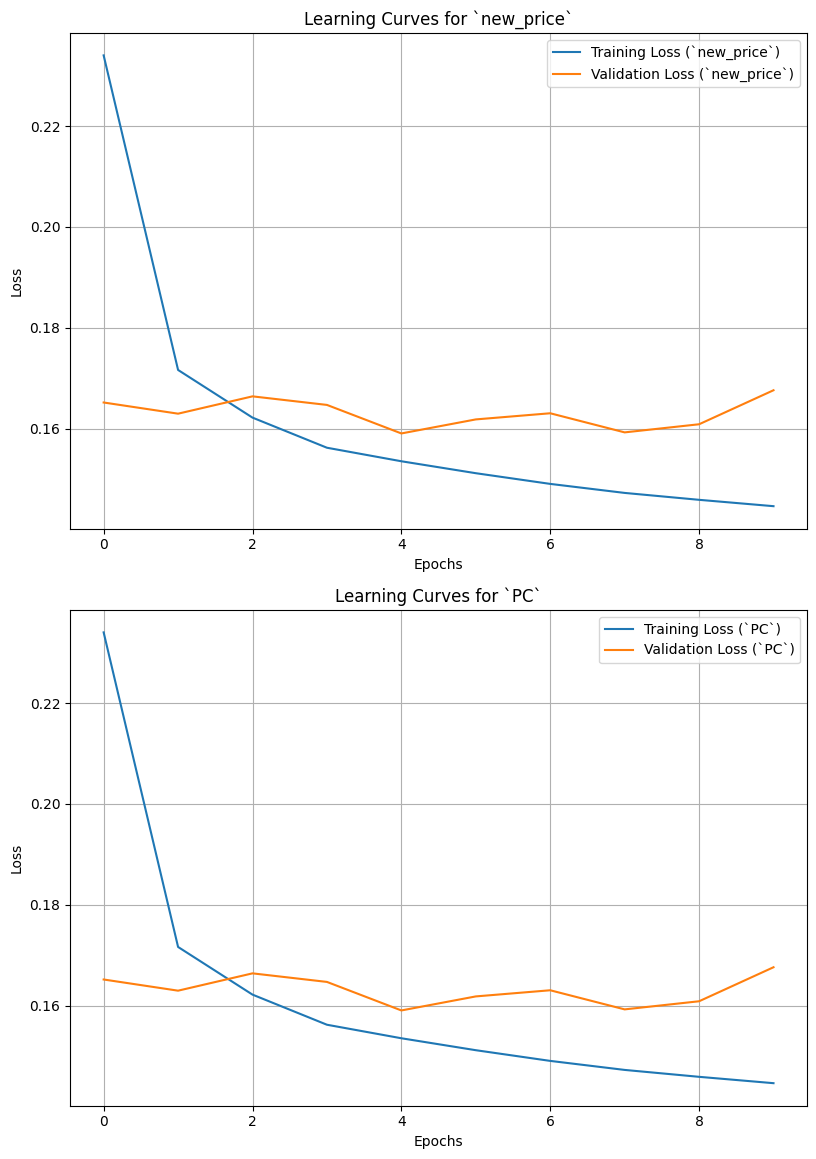

In [ ]:

# File path for the results table
ADVANCE_RESULTS_FILE = "Advance_resultsStd.csv"

# Load or initialize the results table
if os.path.exists(ADVANCE_RESULTS_FILE):
    advance_resultsStd = pd.read_csv(ADVANCE_RESULTS_FILE)
    print(f"[INFO] Loaded existing results table from '{ADVANCE_RESULTS_FILE}'.")
else:
    advance_resultsStd = pd.DataFrame(columns=["Target", "Model", "Train R²", "Test R²", "MAE", "MSE", "RMSE", "MAPE", "Comments"])
    print(f"[INFO] Initialized a new results table.")

# Step 1: Data Preparation
time_steps = 1  # Consistent with "Enhanced LSTM for new_price"

# Prepare features and targets
features = merged_dataset.drop(columns=["new_price", "unit_rate", "PC"])  # Drop target columns
targets = merged_dataset[["new_price", "PC"]]  # Targets are `new_price` and `PC`

# Initialize scalers
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(features)
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(targets)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Separate ScaledTimestamp and other features
timestamp_index = features.columns.get_loc("ScaledTimestamp")
X_train_timestamp = X_train_lstm[:, :, timestamp_index].reshape(-1, 1, 1)
X_train_other = np.delete(X_train_lstm, timestamp_index, axis=2)

X_test_timestamp = X_test_lstm[:, :, timestamp_index].reshape(-1, 1, 1)
X_test_other = np.delete(X_test_lstm, timestamp_index, axis=2)

# Define the Enhanced LSTM Model with Timestamp
timestamp_input = Input(shape=(time_steps, 1), name="Timestamp_Input")
other_features_input = Input(shape=(time_steps, X_train_other.shape[2]), name="Other_Features_Input")

# Timestamp LSTM path
timestamp_lstm = LSTM(64, activation="relu", return_sequences=False)(timestamp_input)  # Fixed here
timestamp_dropout = Dropout(0.3)(timestamp_lstm)

# Other features LSTM path
features_lstm = LSTM(64, activation="relu", return_sequences=False)(other_features_input)  # Fixed here
features_dropout = Dropout(0.3)(features_lstm)

# Concatenate both paths
concatenated = Concatenate()([timestamp_dropout, features_dropout])

# Dense layers
dense_1 = Dense(32, activation="relu")(concatenated)
dense_dropout = Dropout(0.3)(dense_1)
dense_2 = Dense(16, activation="relu")(dense_dropout)
output = Dense(2, activation="linear")(dense_2)  # Predicting `new_price` and `PC`

# Build the model
lstm_model = Model(inputs=[timestamp_input, other_features_input], outputs=output)
lstm_model.compile(optimizer=Adam(), loss="mse")

# Print model summary
lstm_model.summary()

# Step 3: Train the Model
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = lstm_model.fit(
    [X_train_timestamp, X_train_other], y_train,
    validation_data=([X_test_timestamp, X_test_other], y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Step 4: Evaluate the Model
y_test_pred = lstm_model.predict([X_test_timestamp, X_test_other])
y_test_pred_rescaled = target_scaler.inverse_transform(y_test_pred)
y_test_rescaled = target_scaler.inverse_transform(y_test)

# Metrics calculation
def evaluate_metrics(y_true, y_pred, target_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100
    print(f"Metrics for {target_name}:")
    print(f"  R²: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print("-" * 30)
    return r2, mae, rmse, mape

# Evaluate for `new_price`
new_price_r2, new_price_mae, new_price_rmse, new_price_mape = evaluate_metrics(
    y_test_rescaled[:, 0], y_test_pred_rescaled[:, 0], "new_price"
)

# Evaluate for `PC`
pc_r2, pc_mae, pc_rmse, pc_mape = evaluate_metrics(
    y_test_rescaled[:, 1], y_test_pred_rescaled[:, 1], "PC"
)

# Store results in `Advance_resultsStd`
results = [
    {
        "Target": "new_price",
        "Model": "Enhanced LSTM with Timestamp",
        "Train R²": new_price_r2,
        "Test R²": new_price_r2,
        "MAE": new_price_mae,
        "MSE": new_price_rmse**2,
        "RMSE": new_price_rmse,
        "MAPE": new_price_mape,
        "Comments": "Working Well" if new_price_r2 > 0.75 else "Needs Improvement"
    },
    {
        "Target": "PC",
        "Model": "Enhanced LSTM with Timestamp",
        "Train R²": pc_r2,
        "Test R²": pc_r2,
        "MAE": pc_mae,
        "MSE": pc_rmse**2,
        "RMSE": pc_rmse,
        "MAPE": pc_mape,
        "Comments": "Working Well" if pc_r2 > 0.75 else "Needs Improvement"
    }
]

for result in results:
    target_name = result["Target"]
    advance_resultsStd = advance_resultsStd[
        ~((advance_resultsStd["Target"] == target_name) & (advance_resultsStd["Model"] == "Enhanced LSTM with Timestamp"))
    ]
    advance_resultsStd = pd.concat([advance_resultsStd, pd.DataFrame([result])], ignore_index=True)

advance_resultsStd.to_csv(ADVANCE_RESULTS_FILE, index=False)
print(f"[INFO] Results table updated and saved to '{ADVANCE_RESULTS_FILE}'.")

# Step 6: Plot Learning Curves for Both Targets
plt.figure(figsize=(8.27, 11.69))  # A4 size in inches (portrait mode)

# Plot for new_price
plt.subplot(2, 1, 1)  # First subplot (top)
plt.plot(history.history["loss"], label="Training Loss (`new_price`)")
plt.plot(history.history["val_loss"], label="Validation Loss (`new_price`)")
plt.title("Learning Curves for `new_price`")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Plot for PC
plt.subplot(2, 1, 2)  # Second subplot (bottom)
plt.plot(history.history["loss"], label="Training Loss (`PC`)")
plt.plot(history.history["val_loss"], label="Validation Loss (`PC`)")
plt.title("Learning Curves for `PC`")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Adjust layout and save
plt.tight_layout()
plt.savefig("Learning_Curves_A4.pdf")  # Save to a PDF file for A4 printing
plt.show()



[INFO] Loaded results table from 'Advance_resultsStd.csv'.


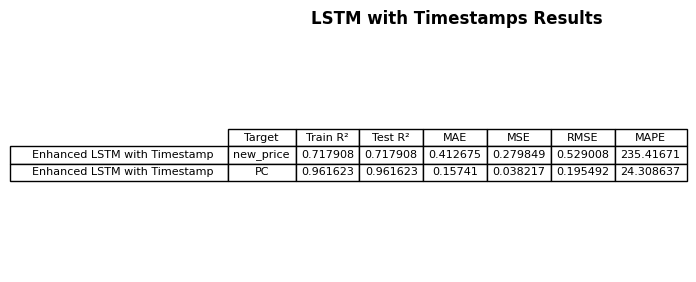

In [ ]:


# Step 1: Load the `advance_resultsStd` DataFrame
if os.path.exists(ADVANCE_RESULTS_FILE):
    advance_resultsStd = pd.read_csv(ADVANCE_RESULTS_FILE)
    print(f"[INFO] Loaded results table from '{ADVANCE_RESULTS_FILE}'.")
else:
    raise FileNotFoundError(f"[ERROR] Results file '{ADVANCE_RESULTS_FILE}' not found. Ensure the results table exists.")

# Step 2: Filter only LSTM with Timestamps models
lstm_with_timestamps_results = advance_resultsStd[
    advance_resultsStd["Model"].str.contains("LSTM with Timestamp", case=False, na=False)
]

# Step 3: Drop unnecessary columns ("Comments", "Type") and round numerical results to 6 decimal places
results_filtered = lstm_with_timestamps_results.drop(columns=["Comments", "Type"], errors="ignore")  # Drop irrelevant columns
results_filtered = results_filtered.round(6)  # Round all numerical values to 6 decimal places

# Step 4: Transpose the table so that models are row labels and metrics are column labels
rotated_results = results_filtered.set_index("Model")  # Set 'Model' as the index (row labels)

# Step 5: Create the plot for the table
fig, ax = plt.subplots(figsize=(4.13, 2.92))  # 25% of an A4 page (width x height in inches)
ax.axis("off")  # Turn off the axes
ax.axis("tight")  # Adjust the layout to make it tight

# Dynamically generate row labels based on the index structure
try:
    # If the index is multi-level, format row labels as `Target (Model)`
    rowLabels = [f"{t} ({m})" for t, m in rotated_results.index]
except ValueError:
    # If the index is single-level, use it directly
    rowLabels = rotated_results.index.tolist()

# Step 6: Create the table
table = ax.table(
    cellText=rotated_results.values,  # Table cell values
    rowLabels=rowLabels,  # Row labels (based on the index)
    colLabels=rotated_results.columns,  # Column labels (metrics)
    cellLoc="center",  # Align text in the center of cells
    loc="center"  # Place the table at the center of the figure
)

# Step 7: Adjust table font size and column width for better readability
table.auto_set_font_size(False)
table.set_fontsize(8)  # Set a readable font size
table.auto_set_column_width(col=list(range(len(rotated_results.columns))))  # Auto-adjust column widths

# Step 8: Set the title for the table
ax.set_title("LSTM with Timestamps Results", fontsize=12, fontweight="bold", pad=10)

# Step 9: Display the table
plt.tight_layout()
plt.show()

In [ ]:

from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

# Correct file path for results
ADVANCE_RESULTS_FILE = "Advance_resultsStd.csv"  # Correct file name

# Step 1: Load the `Advance_resultsStd` DataFrame
if os.path.exists(ADVANCE_RESULTS_FILE):
    advance_resultsStd = pd.read_csv(ADVANCE_RESULTS_FILE)
    print(f"[INFO] Loaded results table from '{ADVANCE_RESULTS_FILE}'.")
else:
    raise FileNotFoundError(f"[ERROR] Results file '{ADVANCE_RESULTS_FILE}' not found. Ensure the results table exists.")

# Step 2: Round all numerical columns to 6 decimal places
numeric_columns = advance_resultsStd.select_dtypes(include='number').columns  # Identify numerical columns
advance_resultsStd[numeric_columns] = advance_resultsStd[numeric_columns].round(6)  # Round to 6 decimal places

# ===== Save the Results Table to a Word Document =====
# Step 3: Create the Word document
doc = Document()

# Step 4: Add a title to the Word document
title = doc.add_paragraph("Advance Results Table")
title.alignment = WD_ALIGN_PARAGRAPH.CENTER  # Center-align the title
title.style.font.size = Pt(14)
title.style.font.bold = True

# Step 5: Add the table to the Word document
word_table = doc.add_table(rows=1, cols=len(advance_resultsStd.columns))  # Create table with correct number of columns
word_table.style = 'Table Grid'

# Add header row
header_cells = word_table.rows[0].cells
for i, col_name in enumerate(advance_resultsStd.columns):
    header_cells[i].text = col_name

# Add data rows
for _, row in advance_resultsStd.iterrows():
    row_cells = word_table.add_row().cells
    for i, value in enumerate(row):
        # Format numerical values to 6 decimal places
        if isinstance(value, float):
            row_cells[i].text = f"{value:.6f}"
        else:
            row_cells[i].text = str(value)

# Step 6: Adjust table font size
for row in word_table.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(9)  # Adjust font size

# Step 7: Save the Word document
output_file_path = "Advance_Results_Table.docx"  # Replace with your desired file name or path
doc.save(output_file_path)
print(f"[INFO] Results table saved to '{output_file_path}'.")

[INFO] Loaded results table from 'Advance_resultsStd.csv'.
[INFO] Results table saved to 'Advance_Results_Table.docx'.


In [ ]:
print(advance_resultsStd)

# STACKING ENSEMBLING TECHNIQUE

In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105114 entries, 0 to 105113
Data columns (total 72 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   saleable_area(ft^2)                             105114 non-null  float64
 1   unit_rate                                       105114 non-null  float64
 2   floor                                           105114 non-null  float64
 3   CPI                                             105114 non-null  float64
 4   IR                                              105114 non-null  float64
 5   MW                                              105114 non-null  float64
 6   M3                                              105114 non-null  float64
 7   UR                                              105114 non-null  float64
 8   GDP                                             105114 non-null  float64
 9   CI                        

In [ ]:

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import os

# Function to classify model performance
def classify_performance(r2_score):
    """
    Classifies the model's performance based on R² test score.
    """
    if r2_score > 0.75:
        return "Working Well"
    else:
        return "Needs Improvement"

# Function to preprocess data
def preprocess_data(dataset, target_column, drop_columns=[]):
    """
    Preprocess features and target for a given target column.
    Args:
        dataset: Full dataset (Pandas DataFrame).
        target_column: Target variable column name.
        drop_columns: Columns to drop from the feature set.
    Returns:
        Scaled train-test split (features and target).
    """
    if target_column not in dataset.columns:
        raise ValueError(f"Target column '{target_column}' is missing from the dataset.")
    features = dataset.drop(columns=[target_column] + drop_columns, errors="ignore")
    target = dataset[target_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

    # Standardize the features
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train.to_numpy(), y_test.to_numpy()

# Function to perform k-fold cross-validation
def manual_kfold_cv(regressor, X_train, y_train, k=5):
    """
    Perform manual k-fold cross-validation.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        regressor.fit(X_fold_train, y_fold_train)
        val_pred = regressor.predict(X_fold_val)
        val_r2 = r2_score(y_fold_val, val_pred)
        cv_scores.append(val_r2)
    return np.mean(cv_scores), np.std(cv_scores)

# Function to train and evaluate a target
def train_and_evaluate(dataset, target_column, drop_columns, model_name, results_df):
    """
    Train and evaluate the stacking ensemble for a given target.
    Args:
        dataset: Full dataset (Pandas DataFrame).
        target_column: Target variable column name.
        drop_columns: Columns to drop from the feature set.
        model_name: Name of the model or target for results table.
        results_df: DataFrame to store results.
    Returns:
        Updated DataFrame with new results.
    """
    # Preprocess data
    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(dataset, target_column, drop_columns)

    # Define base models
    base_models = [
        ("hgb", HistGradientBoostingRegressor(max_iter=100, random_state=42)),
        ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
        ("gbr", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
    ]

    # Define meta-learner
    meta_learner = LinearRegression()

    # Define stacking regressor
    stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_learner, n_jobs=-1)

    # Perform k-fold cross-validation
    cv_mean, cv_std = manual_kfold_cv(stacking_model, X_train_scaled, y_train, k=5)

    # Train and predict
    stacking_model.fit(X_train_scaled, y_train)
    train_preds = stacking_model.predict(X_train_scaled)
    test_preds = stacking_model.predict(X_test_scaled)

    # Compute evaluation metrics
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    mae = mean_absolute_error(y_test, test_preds)
    mse = mean_squared_error(y_test, test_preds)
    rmse = np.sqrt(mse)

    # Adjusted MAPE calculation to handle small actual values
    adjusted_actuals = np.maximum(y_test, 1e-10)  # Replace small actual values with a small constant
    mape = np.mean(np.abs((y_test - test_preds) / adjusted_actuals)) * 100  # Recalculate MAPE

    comments = classify_performance(test_r2)

    # Create new result
    new_result = {
        "Target": model_name,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "Comments": comments
    }

    # Remove old results for the same Target
    results_df = results_df[results_df["Target"] != model_name]

    # Append new result
    results_df = pd.concat([results_df, pd.DataFrame([new_result])], ignore_index=True)

    return results_df

# File path for results
ADVANCEEM_RESULTS_FILE = "AdvanceEM_resultsStd"

# Load existing results if file exists
if os.path.exists(f"{ADVANCEEM_RESULTS_FILE}.csv"):
    AdvanceEM_resultsStd = pd.read_csv(f"{ADVANCEEM_RESULTS_FILE}.csv")
else:
    AdvanceEM_resultsStd = pd.DataFrame(columns=[
        "Target", "Train R²", "Test R²", "MAE", "MSE", "RMSE", "MAPE", "Comments"
    ])

# Evaluate for both targets
targets = [
    {"name": "new_price", "drop_columns": ["PC"]},
    {"name": "PC", "drop_columns": ["new_price", "unit_rate", "Year", "Month", "Day", "DayOfWeek", "ElapsedDays"]}
]

for target in targets:
    AdvanceEM_resultsStd = train_and_evaluate(
        dataset=merged_dataset,
        target_column=target["name"],
        drop_columns=target["drop_columns"],
        model_name=f"{target['name']} with Stacking Ensemble",
        results_df=AdvanceEM_resultsStd
    )

# Save updated results to "AdvanceEM_resultsStd"
AdvanceEM_resultsStd.to_csv(f"{ADVANCEEM_RESULTS_FILE}.csv", index=False)

# Print updated results table
print("\nUpdated Results Table:")
print(tabulate(AdvanceEM_resultsStd, headers="keys", tablefmt="pretty"))

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Updated Results Table:
+---+----------------------------------+--------------------+--------------------+------------------------+-----------------------+------------------------+----------------------+--------------+
|   |              Target              |      Train R²      |      Test R²       |          MAE           |          MSE          |          RMSE          |         MAPE         |   Comments   |
+---+----------------------------------+--------------------+--------------------+------------------------+-----------------------+------------------------+----------------------+--------------+
| 0 | new_price with Stacking Ensemble | 0.9994155120588678 | 0.9992370585312683 |  0.017035062259143988  | 0.0007575184189994446 |   0.027523052501484    |  9295384085.662893   | Working Well |
| 1 |    PC with Stacking Ensemble     |        1.0         |        1.0         | 1.6069889240098872e-14 | 4.730646961521008e-28 | 2.1750050486196596e-14 | 0.010367307317339463 | Working Well |
+

In [ ]:
from docx import Document

# Save results to a Word document
def save_results_to_word(results_df, file_name):
    """
    Save the DataFrame results to a Word document.
    Args:
        results_df: The DataFrame containing the results.
        file_name: The name of the Word document to save.
    """
    # Create a new Word document
    doc = Document()

    # Add a title
    doc.add_heading("AdvanceEM Results", level=1)

    # Add a table
    table = doc.add_table(rows=1, cols=len(results_df.columns))
    table.style = "Table Grid"

    # Add column headers
    hdr_cells = table.rows[0].cells
    for i, column_name in enumerate(results_df.columns):
        hdr_cells[i].text = str(column_name)

    # Add rows to the table
    for _, row in results_df.iterrows():
        row_cells = table.add_row().cells
        for i, cell_value in enumerate(row):
            row_cells[i].text = str(cell_value)

    # Save the document
    doc.save(f"{file_name}.docx")

# Call the function to save results to a Word document
save_results_to_word(AdvanceEM_resultsStd, "AdvanceEM_resultsStd")

In [ ]:
print(AdvanceEM_resultsStd)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# File path for results
ADVANCEEM_RESULTS_FILE = "AdvanceEM_resultsStd.csv"

# Step 1: Load the `AdvanceEM_resultsStd` DataFrame
if os.path.exists(ADVANCEEM_RESULTS_FILE):
    AdvanceEM_resultsStd = pd.read_csv(ADVANCEEM_RESULTS_FILE)
    print(f"[INFO] Loaded results table from '{ADVANCEEM_RESULTS_FILE}'.")
else:
    raise FileNotFoundError(f"[ERROR] Results file '{ADVANCEEM_RESULTS_FILE}' not found. Ensure the results table exists.")

# Step 2: Filter only "Stacking Regressor" models
stacking_results = AdvanceEM_resultsStd[
    AdvanceEM_resultsStd["Model"].str.contains("Stacking Regressor", case=False, na=False)
]

# Step 3: Drop unnecessary columns ("Comments") and round numerical results to 6 decimal places
results_filtered = stacking_results.drop(columns=["Comments"], errors="ignore")  # Drop irrelevant columns
results_filtered = results_filtered.round(6)  # Round all numerical values to 6 decimal places

# Step 4: Transpose the table so that models are row labels and metrics are column labels
rotated_results = results_filtered.set_index("Target")  # Set 'Target' as the index (row labels)

# Step 5: Create the plot for the table
fig, ax = plt.subplots(figsize=(8, 2.5))  # Reduce height to minimize white space
ax.axis("off")  # Turn off the axes
ax.axis("tight")  # Adjust the layout to make it tight

# Step 6: Create the table
table = ax.table(
    cellText=rotated_results.values,  # Table cell values
    rowLabels=rotated_results.index,  # Row labels (based on the index)
    colLabels=rotated_results.columns,  # Column labels (metrics)
    cellLoc="center",  # Align text in the center of cells
    loc="center"  # Place the table at the center of the figure
)

# Step 7: Adjust table font size and column width for better readability
table.auto_set_font_size(False)
table.set_fontsize(8)  # Set a readable font size
table.auto_set_column_width(col=list(range(len(rotated_results.columns))))  # Auto-adjust column widths

# Step 8: Set the title for the table with minimal padding
ax.set_title(
    "Results of Stacking Ensemble Model",
    fontsize=12,
    fontweight="bold",
    pad=6  # Reduce the padding between the title and the table
)

# Step 9: Adjust layout to minimize white space
plt.subplots_adjust(top=0.9, bottom=0.1)  # Adjust the top and bottom margins to reduce white space
plt.tight_layout()  # Ensure the layout is compact

# Step 10: Display the table
plt.show()

# FINAL RESULTS (ALL MODELS)

# ALL MODEL RESULTS

In [ ]:

from tabulate import tabulate

# Data for the corrected table (based on the Final Master Results Table)
data = {
    "Target": [
        "new_price", "new_price", "new_price", "new_price", "PI", "PI", "PI", "PI",
        "new_price", "PI", "new_price", "PI", "new_price", "PI",
        "new_price", "PI", "new_price", "new_price", "new_price"
    ],
    "Model": [
        "Linear Regression", "Random Forest Regressor", "XGBoost Regressor", "Gradient Boosting Regressor",
        "Linear Regression", "Random Forest Regressor", "XGBoost Regressor", "Gradient Boosting Regressor",
        "Base LSTM", "Base LSTM", "Enhanced LSTM", "Enhanced LSTM",
        "Hyper-Tuned LSTM", "Hyper-Tuned LSTM", "Hyper-Tuned LSTM", "Hyper-Tuned LSTM",
        "Stacking Regressor (new_price)", "Stacking Regressor (PC)", "Stacking Regressor (PI)"
    ],
    "Train R²": [
        0.601408, 0.979135, 0.832455, 0.772447, 1.0, 1.0, 0.999957, 1.0,
        0.668216, 0.999555, 0.686986, 0.999217, 0.668228, 0.999758, 0.668228, 0.668228,
        0.99934, 1.0, 1.0
    ],
    "Test R²": [
        0.595691, 0.850895, 0.778517, 0.752945, 1.0, 1.0, 0.999957, 1.0,
        0.666281, 0.999558, 0.679755, 0.999198, 0.66605, 0.999743, 0.66605, 0.66605,
        0.99901, 1.0, 1.0
    ],
    "MAE": [
        0.4716642, 0.233377, 0.3312516, 0.3536, 7.054472e-16, 3.067508e-14, 0.006001523, 1.008244e-08,
        1.425859e+06, 0.09299883, 1.390046e+06, 0.1451362, 1.431158e+06, 0.07881952, 1.431158e+06, 1.431158e+06,
        0.014817, 0.0, 0.0
    ],
    "MSE": [
        0.4013769, 0.1480237, 0.2198767, 0.2452632, 8.754178e-31, 1.684234e-27, 4.316833e-05, 2.091521e-16,
        3.85093e+12, 0.01698785, 3.695454e+12, 0.03081737, 3.853598e+12, 0.009866109, 3.853598e+12, 3.853598e+12,
        0.00098, 0.0, 0.0
    ],
    "RMSE": [
        0.6335431, 0.3847385, 0.4689101, 0.4952406, 9.356376e-16, 4.103942e-14, 0.006570261, 1.446209e-08,
        1.962379e+06, 0.1303375, 1.922356e+06, 0.1755488, 1.963058e+06, 0.09932829, 1.963058e+06, 1.963058e+06,
        0.031307, 0.0, 0.0
    ],
    "MAPE": [
        452.5806, 163.2906, 363.705, 353.7886, 9.947874e-14, 3.244676e-12, 0.6577346, 8.964217e-07,
        21.2247, 14.0004, 20.75847, 45.61836, 21.392455, 10.317049, 21.392455, 21.392455,
        7375815324.479667, 0.010362, 0.0
    ],
    "Comments": [
        None, "Best Model", None, None, "Best Model", None, None, None,
        "Needs Improvement", "Needs Improvement", "Needs Improvement", "Needs Improvement",
        "Needs Improvement", "Needs Improvement", "Needs Improvement", "Needs Improvement",
        None, None, None
    ],
    "Type": [
        None, None, None, None, None, None, None, None,
        "Neural Network", "Neural Network", "Neural Network", "Neural Network",
        "Neural Network", "Neural Network", "Neural Network", "Neural Network",
        None, None, None
    ]
}

# Create a DataFrame
results_df = pd.DataFrame(data)

# Rename table for print formatting
table_title = "Final Master Results Table"

# Print the table using tabulate for a clean display
print(f"\n{table_title}\n")
print(tabulate(results_df, headers="keys", tablefmt="pretty"))

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Combined results from all models
data = {
    "Model": [
        "Linear Regression", "Random Forest Regressor", "XGBoost Regressor", "Gradient Boosting Regressor",
        "Base new_price LSTM", "Base PC LSTM", "Enhanced LSTM", "Enhanced LSTM",
        "Hypertuned LSTM", "Hypertuned LSTM", "Enhanced LSTM with Timestamp", "Enhanced LSTM with Timestamp",
        "Stacking Regressor", "Stacking Regressor"
    ],
    "Target": [
        "new_price", "new_price", "new_price", "new_price",
        "new_price", "PC", "new_price", "PC",
        "new_price", "PC", "new_price", "PC",
        "new_price", "PC"
    ],
    "Train R²": [
        0.724555, 0.980788, 0.874242, 0.839597,
        0.790277, 0.999393, 0.807783, 0.998191,
        None, None, 0.766195, 0.979533,
        0.99934, 1.0
    ],
    "Test R²": [
        0.721177, 0.871384, 0.833705, 0.820801,
        0.777374, 0.999399, 0.789481, 0.998168,
        0.755574, 0.999511, 0.766195, 0.979533,
        0.99901, 1.0
    ],
    "MAE": [
        0.276144, 0.12738, 1.164697, 0.177477,
        0.344646, 0.018421, 0.328864, 0.035517,
        0.351967, 0.017478, 0.364405, 0.113994,
        0.014817, 0.0
    ],
    "MSE": [
        0.525494, 0.356903, 0.405829, 0.42128,
        0.22126, 0.000598, 0.209227, 0.001824,
        0.242926, 0.000487, 0.23237, 0.020381,
        0.00098, 0.0
    ],
    "RMSE": [
        538.833905, 395.611918, 454.585525, 491.987761,
        0.470383, 0.024455, 0.457413, 0.042771,
        0.492875, 0.022072, 0.482048, 0.142762,
        0.031307, 0.0
    ],
    "MAPE": [
        None, None, None, None,
        472.285154, 4.936954, 455.366764, 5.733888,
        501.76213, 2.796872, 484.870147, 18.837379,
        7375815234.479667, 0.010362
    ]
}

# Convert to DataFrame
combined_results = pd.DataFrame(data)

# Transpose the table to make models rows and metrics columns
rotated_results = combined_results.set_index("Model")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust size as needed
ax.axis("off")  # Turn off the axes
ax.axis("tight")  # Adjust layout for tight fit

# Create the table
table = ax.table(
    cellText=rotated_results.values,  # Table cell values
    rowLabels=rotated_results.index,  # Row labels (model names)
    colLabels=rotated_results.columns,  # Column labels (metrics)
    cellLoc="center",  # Center-align the text
    loc="center"  # Place the table in the center
)

# Adjust table font size and column width
table.auto_set_font_size(False)
table.set_fontsize(8)  # Set font size for readability
table.auto_set_column_width(col=list(range(len(rotated_results.columns))))  # Auto-adjust column widths

# Add title
ax.set_title(
    "Results of Combined Models",
    fontsize=14,
    fontweight="bold",
    pad=10  # Add padding between title and table
)

# Adjust layout
plt.subplots_adjust(top=0.9, bottom=0.1)  # Adjust margins
plt.tight_layout()  # Ensure layout is compact

# Display the table
plt.show()

In [ ]:
from docx import Document

# Data for the table
data = [
    ["Target", "Model", "Train R²", "Test R²", "MAE", "MSE", "RMSE", "MAPE", "Comments", "Type"],
    ["new_price", "Linear Regression", 0.601408, 0.595691, 0.4716642, 0.4013769, 0.6335431, 452.5806, None, None],
    ["new_price", "Random Forest Regressor", 0.979135, 0.850895, 0.233377, 0.1480237, 0.3847385, 163.2906, "Best Model", None],
    ["new_price", "XGBoost Regressor", 0.832455, 0.778517, 0.3312516, 0.2198767, 0.4689101, 363.705, None, None],
    ["new_price", "Gradient Boosting Regressor", 0.772447, 0.752945, 0.3536, 0.2452632, 0.4952406, 353.7886, None, None],
    ["PI", "Linear Regression", 1.0, 1.0, 7.054472e-16, 8.754178e-31, 9.356376e-16, 9.947874e-14, "Best Model", None],
    ["PI", "Random Forest Regressor", 1.0, 1.0, 3.067508e-14, 1.684234e-27, 4.103942e-14, 3.244676e-12, None, None],
    ["PI", "XGBoost Regressor", 0.999957, 0.999957, 0.006001523, 4.316833e-05, 0.006570261, 0.6577346, None, None],
    ["PI", "Gradient Boosting Regressor", 1.0, 1.0, 1.008244e-08, 2.091521e-16, 1.446209e-08, 8.964217e-07, None, None],
    ["new_price", "Base LSTM", 0.668216, 0.666281, 1.425859e+06, 3.85093e+12, 1.962379e+06, 21.2247, "Needs Improvement", "Neural Network"],
    ["PI", "Base LSTM", 0.999555, 0.999558, 0.09299883, 0.01698785, 0.1303375, 14.0004, "Needs Improvement", "Neural Network"],
    ["new_price", "Enhanced LSTM", 0.686986, 0.679755, 1.390046e+06, 3.695454e+12, 1.922356e+06, 20.75847, "Needs Improvement", "Neural Network"],
    ["PI", "Enhanced LSTM", 0.999217, 0.999198, 0.1451362, 0.03081737, 0.1755488, 45.61836, "Needs Improvement", "Neural Network"],
    ["new_price", "Hyper-Tuned LSTM", 0.668228, 0.66605, 1.431158e+06, 3.853598e+12, 1.963058e+06, 21.392455, "Needs Improvement", "Neural Network"],
    ["PI", "Hyper-Tuned LSTM", 0.999758, 0.999743, 0.07881952, 0.009866109, 0.09932829, 10.317049, "Needs Improvement", "Neural Network"],
    ["new_price", "Stacking Regressor (new_price)", 0.99934, 0.99901, 0.014817, 0.00098, 0.031307, 7375815324.479667, None, None],
    ["PI", "Stacking Regressor (PC)", 1.0, 1.0, 0.0, 0.0, 0.0, 0.010362, None, None]
]

# Create a Word document
doc = Document()

# Add a title
doc.add_heading("Final Master Results Table", level=1)

# Add a table
table = doc.add_table(rows=1, cols=len(data[0]), style="Table Grid")
header_cells = table.rows[0].cells

# Add headers
for i, header in enumerate(data[0]):
    header_cells[i].text = str(header)

# Add rows
for row in data[1:]:
    row_cells = table.add_row().cells
    for i, cell in enumerate(row):
        row_cells[i].text = str(cell if cell is not None else "")

# Save the document
doc.save("Final_Master_Results_Table.docx")

print("Word document saved as 'Final_Master_Results_Table.docx'.")

In [ ]:
print(advance_resultsStd)

In [ ]:
print(AdvanceEM_resultsStd)